# Trying out different k values for kNN

In [1]:
MODEL_PATHS = ['../saved_models/10x_tune_single_scRNA_epoch_00150.pt', '../saved_models/10x_tune_single_cnn_epoch_00300.pt', '../saved_models/10x_tune_joint_cnn_epoch_00100.pt'] 
NAMES = ['single scRNA', 'single CNN', 'joint CNN']

In [2]:
import sys
sys.path.insert(0, '..')
import tcr_embedding as tcr
import scanpy as sc
import json
from matplotlib import rcParams
import matplotlib.pyplot as plt
import torch
from tcr_embedding.evaluation.WrapperFunctions import get_model_prediction_function
from tcr_embedding.evaluation.Imputation import run_imputation_evaluation
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

path_data = '../data/10x_CD8TC/v5_train_val_test.h5ad'
data_full = sc.read_h5ad(path_data)
data_full = data_full[data_full.obs['set'] != 'test']

In [4]:
all_models_f1 = {}
all_models_results = {}
for MODEL_PATH, NAME in zip(MODEL_PATHS, NAMES):
    model_file = torch.load(MODEL_PATH)

    params = model_file['params']
    params

    if 'single' in MODEL_PATH:
        trained_model = tcr.models.single_model.SingleModel(
                adatas=[data_full],  # adatas containing gene expression and TCR-seq
                names=['10x'],
                aa_to_id=data_full.uns['aa_to_id'],  # dict {aa_char: id}
                seq_model_arch=params['seq_model_arch'],  # seq model architecture
                seq_model_hyperparams=params['seq_model_hyperparams'],  # dict of seq model hyperparameters
                scRNA_model_arch=params['scRNA_model_arch'],
                scRNA_model_hyperparams=params['scRNA_model_hyperparams'],
                zdim=params['zdim'],  # zdim
                hdim=params['hdim'],  # hidden dimension of scRNA and seq encoders
                activation=params['activation'],  # activation function of autoencoder hidden layers
                dropout=params['dropout'],
                batch_norm=params['batch_norm'],
                shared_hidden=params['shared_hidden'],  # hidden layers of shared encoder / decoder
                gene_layers=[],  # [] or list of str for layer keys of each dataset
                seq_keys=[]  # [] or list of str for seq keys of each dataset
            )
    else:
        trained_model = tcr.models.joint_model.JointModel(
                adatas=[data_full],  # adatas containing gene expression and TCR-seq
                names=['10x'],
                aa_to_id=data_full.uns['aa_to_id'],  # dict {aa_char: id}
                seq_model_arch=params['seq_model_arch'],  # seq model architecture
                seq_model_hyperparams=params['seq_model_hyperparams'],  # dict of seq model hyperparameters
                scRNA_model_arch=params['scRNA_model_arch'],
                scRNA_model_hyperparams=params['scRNA_model_hyperparams'],
                zdim=params['zdim'],  # zdim
                hdim=params['hdim'],  # hidden dimension of scRNA and seq encoders
                activation=params['activation'],  # activation function of autoencoder hidden layers
                dropout=params['dropout'],
                batch_norm=params['batch_norm'],
                shared_hidden=params['shared_hidden'],  # hidden layers of shared encoder / decoder
                gene_layers=[],  # [] or list of str for layer keys of each dataset
                seq_keys=[]  # [] or list of str for seq keys of each dataset
            )
    trained_model.load(MODEL_PATH)

    test_embedding_func = get_model_prediction_function(trained_model, batch_size=1048)

    ks = [1, 3, 5, 10, 30, 50, 100, 300, 500, 1000]
    weighted_f1 = []
    results = {}
    for k in ks:
        summary = run_imputation_evaluation(data_full, test_embedding_func, query_source='val', use_non_binder=True, use_reduced_binders=True, num_neighbors=k)
        results[k] = summary
        weighted_f1.append(summary['knn']['weighted avg']['f1-score'])
        print(f"For {NAME} k={k}: Weighted F1: {summary['knn']['weighted avg']['f1-score']}")
    all_models_results[NAME] = results
    all_models_f1[NAME] = weighted_f1

For single scRNA k=1: Weighted F1: 0.6790521725332405
For single scRNA k=3: Weighted F1: 0.7145559660065228


C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr_update\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr_update\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr_update\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

For single scRNA k=5: Weighted F1: 0.7315856220496898


C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr_update\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr_update\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr_update\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

For single scRNA k=10: Weighted F1: 0.7432929003086897


C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr_update\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr_update\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr_update\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

For single scRNA k=30: Weighted F1: 0.7453966259909989


C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr_update\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr_update\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr_update\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

For single scRNA k=50: Weighted F1: 0.7418743425904829


C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr_update\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr_update\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr_update\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

For single scRNA k=100: Weighted F1: 0.7342140832907544


C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr_update\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr_update\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr_update\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

For single scRNA k=300: Weighted F1: 0.7189837505175929


C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr_update\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr_update\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr_update\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

For single scRNA k=500: Weighted F1: 0.7051101872175004


C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr_update\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr_update\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr_update\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

For single scRNA k=1000: Weighted F1: 0.6780370595890348
For single CNN k=1: Weighted F1: 0.5485303287869365
For single CNN k=3: Weighted F1: 0.5365400942535048


C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr_update\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr_update\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr_update\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

For single CNN k=5: Weighted F1: 0.5517269410677594


C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr_update\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr_update\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr_update\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

For single CNN k=10: Weighted F1: 0.5300743050926022


C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr_update\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr_update\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr_update\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

For single CNN k=30: Weighted F1: 0.512451795895997


C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr_update\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr_update\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr_update\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

For single CNN k=50: Weighted F1: 0.5091357129336846


C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr_update\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr_update\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr_update\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

For single CNN k=100: Weighted F1: 0.5154507427599376


C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr_update\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr_update\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr_update\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

For single CNN k=300: Weighted F1: 0.5153160466823422


C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr_update\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr_update\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr_update\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

For single CNN k=500: Weighted F1: 0.5172692727983421


C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr_update\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr_update\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr_update\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

For single CNN k=1000: Weighted F1: 0.5181960257901185
For joint CNN k=1: Weighted F1: 0.6128934870448925
For joint CNN k=3: Weighted F1: 0.6371966053814012
For joint CNN k=5: Weighted F1: 0.640440336759878


C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr_update\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr_update\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr_update\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

For joint CNN k=10: Weighted F1: 0.6424326206180367


C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr_update\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr_update\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr_update\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

For joint CNN k=30: Weighted F1: 0.641305590307759


C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr_update\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr_update\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr_update\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

For joint CNN k=50: Weighted F1: 0.6360607235869018


C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr_update\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr_update\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr_update\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

For joint CNN k=100: Weighted F1: 0.6279700607594215


C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr_update\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr_update\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr_update\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

For joint CNN k=300: Weighted F1: 0.6084287891865251


C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr_update\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr_update\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr_update\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

For joint CNN k=500: Weighted F1: 0.5956739984982967


C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr_update\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr_update\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


For joint CNN k=1000: Weighted F1: 0.5748971793051022


C:\Users\yanga\AppData\Local\Continuum\anaconda3\envs\tcr_update\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 1.0, 'Comparing different num_neighbor values for kNN antigen specificity imputation')

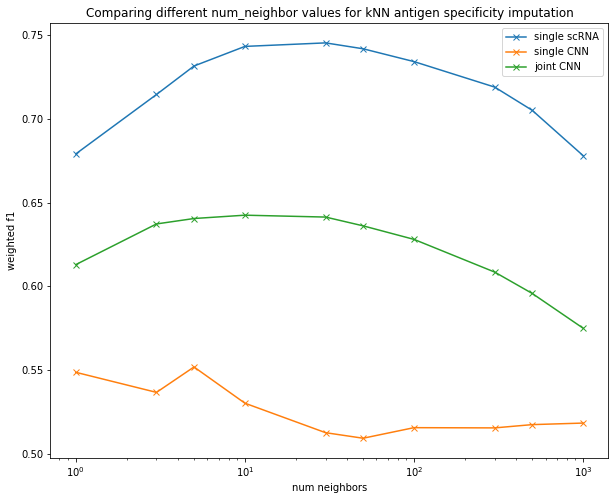

In [10]:
plt.figure(figsize=(10,8))
for key in all_models_f1:
    plt.plot(ks, all_models_f1[key], marker='x', label=key)
plt.xlabel('num neighbors')
plt.ylabel('weighted f1')
plt.legend()
plt.xscale('log')
plt.title('Comparing different num_neighbor values for kNN antigen specificity imputation')